## This notebook demonstrates the neuron sharing phenomenon for 2D inputs

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
from numpy.linalg import inv
import torch.nn.functional as F
from torch.utils.data import Dataset

## Shallow Univariate ReLU Neural Network

In [2]:
# one hidden layer
class Net(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Net, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out, bias=False)

    def forward(self, x):
        x_feat = self.linear1(x)
        h_relu = F.relu(x_feat)
        y_pred = self.linear2(h_relu)

        
        return y_pred

## Generate 2D Data From Neural Net

In [3]:
# generate 2d ridge function with random orientation
n = 50
d = 2
D = 2

# set seed
torch.manual_seed(43)

x_train = torch.randn(n,d)

data_net = Net(d, 5, D)

y_train = data_net(x_train).data

W=2*n # network width

In [4]:
## Original data generating neural nets path norm
v_k = data_net.linear2.weight.data
ws = torch.vstack([data_net.linear1.weight.data.T, data_net.linear1.bias.data])
ws_norm = torch.linalg.norm(ws, dim=0, ord=2)
vs_norm = torch.linalg.norm(v_k, dim=0, ord=2)

path_norm_orig = torch.sum(ws_norm * vs_norm)
print('VV norm of data generating network: {}'.format(path_norm_orig.item()))

VV norm of data generating network: 0.9980637431144714


## Training Loop

In [5]:
def train_net(x_train, y_train, iter=100001,lr=5e-2, reg=1e-3, rand_seed=49, prox=False):
    eps=1e-8
    torch.manual_seed(rand_seed)
    
    model = Net(2, W, 2)

    pns = []
    actives = []
    err = []


    criterion = torch.nn.MSELoss()

    if prox:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=reg)

    for t in range(iter):
        y_hat = model(x_train)
        loss = criterion(y_hat, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Append bias to weights
        ws = torch.vstack([model.linear1.weight.detach().data.T, model.linear1.bias.detach().data])
        
        
        ws_norm = torch.linalg.norm(ws, dim=0, ord=2)
        v_k = model.linear2.weight.detach().data
        
        
        path_norms = torch.linalg.norm(v_k, dim=0, ord=2)

        if prox:
            ##### Proximal step #####
            lam = lr*reg

            v_k_norm = torch.linalg.vector_norm(v_k, dim=0, ord=2)  # [K,]
            v_k_upd = torch.where(v_k_norm <= lam, torch.zeros_like(v_k),
                                  v_k - lam * v_k / torch.clip(v_k_norm[None, :], min=eps))  # [out_dim, N]

            model.linear2.weight.data = v_k_upd
            model.linear1.weight.data = (ws[:2]/ws_norm).T
            model.linear1.bias.data = ws[2]/ws_norm
            ############################
        
        
        active = torch.sum(path_norms > 1e-3)
        path_norms = torch.linalg.norm(model.linear2.weight.detach().data, dim=0, ord=2)
        pn = torch.sum(path_norms)
        if t % 10000 == 0:
            print('Iter:{}, Loss: {}, Active: {}, PN: {}\n'.format(t, loss.item(), active, pn.item()))
        
        err.append(loss.item())
        pns.append(pn.item())
        actives.append(active)
        

    return model, np.asarray(actives), np.asarray(err), np.asarray(pns)

### Train model with Weight Decay

In [10]:
model_wd, actives_wd, err_wd, pn_wd = train_net(x_train, y_train, iter=1000000, lr=2e-1, reg=5e-5, prox=True)
results_wd = {'model':model_wd, 'sparsity':actives_wd, 'err':err_wd, 'pn': pn_wd}


print('\nFinal Sparsity: {}'.format(actives_wd[-1]))
print('\nFinal MSE Loss: {}'.format(err_wd[-1]))
print('Final VV Norm: {}'.format(pn_wd[-1]))

Iter:0, Loss: 0.2194146364927292, Active: 100, PN: 7.808854103088379

Iter:10000, Loss: 0.0004041828215122223, Active: 89, PN: 61.87083053588867

Iter:20000, Loss: 7.14719935785979e-05, Active: 77, PN: 54.95941925048828

Iter:30000, Loss: 5.3041541832499206e-05, Active: 62, PN: 49.23955154418945

Iter:40000, Loss: 4.589136369759217e-05, Active: 59, PN: 44.22816848754883

Iter:50000, Loss: 3.7276662624208257e-05, Active: 58, PN: 39.484378814697266

Iter:60000, Loss: 3.323933924548328e-05, Active: 55, PN: 35.03184509277344

Iter:70000, Loss: 3.1644933187635615e-05, Active: 50, PN: 30.910057067871094

Iter:80000, Loss: 3.0877381504978985e-05, Active: 49, PN: 26.973041534423828

Iter:90000, Loss: 3.0755541956750676e-05, Active: 46, PN: 23.213489532470703

Iter:100000, Loss: 3.044936602236703e-05, Active: 43, PN: 19.77099609375

Iter:110000, Loss: 3.0175810024957173e-05, Active: 40, PN: 16.686710357666016

Iter:120000, Loss: 2.9745109713985585e-05, Active: 38, PN: 13.795405387878418

Iter:1

## Plotting Neuron Locations

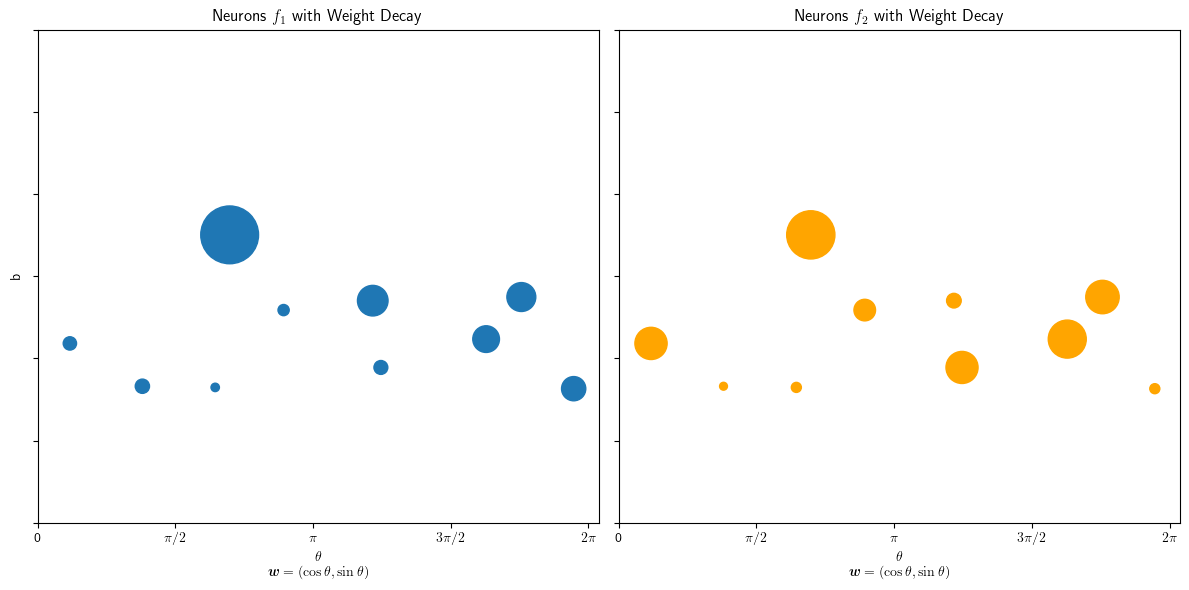

In [27]:
in_weights = model_wd.linear1.weight.data
in_bias = model_wd.linear1.bias.data

in_weights_norm = torch.linalg.norm(in_weights, dim=1, ord=2)

in_weights_unit = in_weights.T / (in_weights_norm)
biases_normalized = in_bias / in_weights_norm

thetas = torch.atan2(in_weights_unit[1, :], in_weights_unit[0, :])
thetas = torch.where(thetas < 0, thetas + 2*np.pi, thetas)

vs = model_wd.linear2.weight.data
vs_homo = vs * in_weights_norm

thetas_out1 = thetas[torch.abs(vs_homo[0,:]) > 1e-3]
biases_normalized_out1 = biases_normalized[torch.abs(vs_homo[0,:]) > 1e-3]

thetas_out2 = thetas[torch.abs(vs_homo[1,:]) > 1e-3]
biases_normalized_out2 = biases_normalized[torch.abs(vs_homo[1,:]) > 1e-3]

import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{bm}')


active_out_weights1_wd = vs_homo[0,:][torch.abs(vs_homo[0,:])>1e-3]
active_out_weights2_wd = vs_homo[1,:][torch.abs(vs_homo[1,:])>1e-3]

fig,[ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
ax1.scatter(thetas_out1, biases_normalized_out1, s=5000*torch.abs(active_out_weights1_wd))

ticks = np.arange(0, 2*np.pi+np.pi/2, np.pi/2)
tick_labels = ['0', '$\pi/2$',  '$\pi$',  '$3\pi/2$','$2\pi$']
ax1.set_xlabel(r'$\theta$'+'\n'+r'$\boldsymbol{w} = (\cos \theta,\sin \theta )$')
ax1.set_xticks(ticks)
ax1.set_xticklabels(tick_labels)
ax1.set_ylabel('b')
ax1.set_ylim([-3,3])
ax1.set_title('Neurons $f_1$ with Weight Decay')

ax2.scatter(thetas_out2, biases_normalized_out2,s=5000*torch.abs(active_out_weights2_wd), color='orange')
ax2.set_xlabel(r'$\theta$'+'\n'+r'$\boldsymbol{w} = (\cos \theta,\sin \theta )$')
ax2.set_xticks(ticks)
ax2.set_xticklabels(tick_labels)
ax2.set_ylim([-3,3])
ax2.set_yticklabels([])
ax2.set_title('Neurons $f_2$ with Weight Decay')

plt.tight_layout()

#plt.savefig('nn_data_f1_neuron_loc_2D_wd.pdf', dpi=500)
plt.show()

## Train Model without Weight Decay

In [14]:
model_no_wd, actives_no_wd, err_no_wd, pn_no_wd = train_net(x_train, y_train, iter=1000000,lr=2e-1, reg=0, prox=False)
results_no_wd = {'model':model_no_wd, 'sparsity':actives_no_wd, 'err':err_no_wd, 'pn': pn_no_wd}


print('\nFinal Sparsity: {}'.format(actives_no_wd[-1]))
print('\nFinal MSE Loss: {}'.format(err_no_wd[-1]))
print('Final VV Norm: {}'.format(pn_no_wd[-1]))

Iter:0, Loss: 0.2194146364927292, Active: 100, PN: 7.8098530769348145

Iter:10000, Loss: 3.7256188534229295e-06, Active: 100, PN: 6.800178527832031

Iter:20000, Loss: 1.6181013506866293e-06, Active: 100, PN: 6.756748199462891

Iter:30000, Loss: 9.625167649573996e-07, Active: 100, PN: 6.740899562835693

Iter:40000, Loss: 6.717923497490119e-07, Active: 100, PN: 6.735079288482666

Iter:50000, Loss: 5.129516011947999e-07, Active: 100, PN: 6.733519554138184

Iter:60000, Loss: 4.1745224166334083e-07, Active: 100, PN: 6.733954906463623

Iter:70000, Loss: 3.4606372878442926e-07, Active: 100, PN: 6.735533237457275

Iter:80000, Loss: 2.9276796453814313e-07, Active: 100, PN: 6.737655162811279

Iter:90000, Loss: 2.505339011804608e-07, Active: 100, PN: 6.740118026733398

Iter:100000, Loss: 2.1654099668921845e-07, Active: 100, PN: 6.742755889892578

Iter:110000, Loss: 1.882974203226695e-07, Active: 100, PN: 6.7455549240112305

Iter:120000, Loss: 1.6432690586043464e-07, Active: 100, PN: 6.74853277206

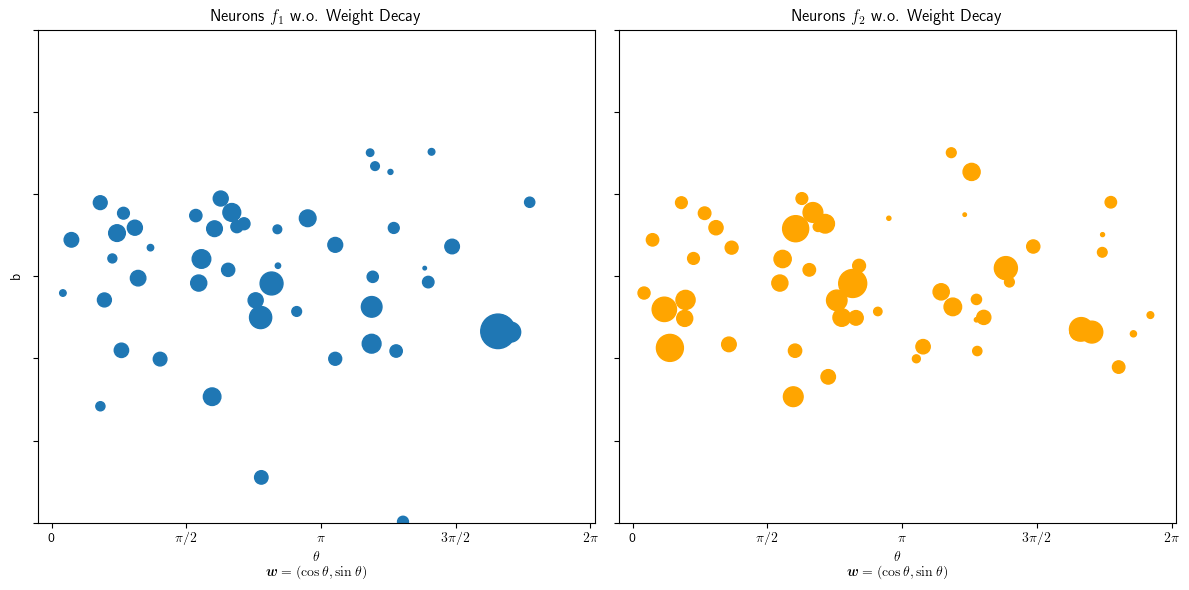

In [30]:
in_weights_no_wd = model_no_wd.linear1.weight.data
in_bias_no_wd = model_no_wd.linear1.bias.data

in_weights_norm_no_wd = torch.linalg.norm(in_weights_no_wd, dim=1, ord=2)
in_weights_unit_no_wd = in_weights_no_wd.T / (in_weights_norm_no_wd)

biases_normalized_no_wd = in_bias_no_wd / in_weights_norm_no_wd

thetas_no_wd = torch.atan2(in_weights_unit_no_wd[1, :], in_weights_unit_no_wd[0, :])
thetas_no_wd = torch.where(thetas_no_wd < 0, thetas_no_wd + 2*np.pi, thetas_no_wd)

vs_no_wd = model_no_wd.linear2.weight.data

vs_homo_no_wd = vs_no_wd * in_weights_norm_no_wd

thetas_out1_no_wd = thetas_no_wd[torch.abs(vs_homo_no_wd[0,:]) > 1e-3]
biases_normalized_out1_no_wd = biases_normalized_no_wd[torch.abs(vs_homo_no_wd[0,:]) > 1e-3]

thetas_out2_no_wd = thetas_no_wd[torch.abs(vs_homo_no_wd[1,:]) > 1e-3]
biases_normalized_out2_no_wd = biases_normalized_no_wd[torch.abs(vs_homo_no_wd[1,:]) > 1e-3]

active_out_weights1 = vs_homo_no_wd[0,:][torch.abs(vs_homo_no_wd[0,:])>1e-3]
active_out_weights2 = vs_homo_no_wd[1,:][torch.abs(vs_homo_no_wd[1,:])>1e-3]

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
ax1.scatter(thetas_out1_no_wd, biases_normalized_out1_no_wd, s=5000*active_out_weights1)

ticks = np.arange(0, 2*np.pi+np.pi/2, np.pi/2)
tick_labels = ['0', '$\pi/2$',  '$\pi$',  '$3\pi/2$','$2\pi$']
ax1.set_xlabel(r'$\theta$'+'\n'+r'$\boldsymbol{w} = (\cos \theta,\sin \theta )$')
ax1.set_xticks(ticks)
ax1.set_xticklabels(tick_labels)
ax1.set_ylabel('b')
ax1.set_ylim([-3,3])
ax1.set_title('Neurons $f_1$ w.o. Weight Decay')

ax2.scatter(thetas_out2_no_wd, biases_normalized_out2_no_wd, s=5000*active_out_weights2, color='orange')
ax2.set_xlabel(r'$\theta$'+'\n'+r'$\boldsymbol{w} = (\cos \theta,\sin \theta )$')
ax2.set_xticks(ticks)
ax2.set_xticklabels(tick_labels)
ax2.set_ylim([-3,3])
ax2.set_yticklabels([])
ax2.set_title('Neurons $f_2$ w.o. Weight Decay')


plt.tight_layout()

#plt.savefig('nn_data_f1_neuron_loc_2D_no_wd.pdf', dpi=500)
plt.show()